In [1]:
import pandas as pd
import numpy as np
from scipy.cluster.hierarchy import linkage
import seaborn as sns
import scipy as sp
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
from pathlib import Path

In [2]:
from module.Ceval.dendrogram_eval import get_clustering_stats

from module.utils import get_w_threshold

from module.wegog_utils import prepare_ego_nhood_graphs, get_ewg_gmds

/Users/ssm47/opt/anaconda3/envs/thesis_env/lib/python3.9/site-packages/graspologic/layouts/colors.py:13: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
/Users/ssm47/opt/anaconda3/envs/thesis_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from module.data_prep_celegans import celegans_data, syn_to_edge, prep_cook_meta

In [4]:

nb_name = '10_celegans_gmd'
cwd = Path.cwd()
save_things=True
if save_things:
    fig_dir = cwd.parent / 'figures' / nb_name
    fig_dir.mkdir(parents=True, exist_ok=True)
# save_things = True

In [5]:
edge_df, ce_meta = celegans_data()

/Users/ssm47/Desktop/thesis_code/03_connectome_gm/src/module/data_prep_celegans.py:74: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  edge_df = pd.read_csv('../../data/celegans/white_1986_whole.csv', delim_whitespace=True)


In [6]:
# ce_meta, lin_data, edge_df = prep_V_data() # this is corrected data:

In [7]:
ce_meta['Cell Class'] = ce_meta['Cell Class'].astype(str)

In [8]:
chem_edges_df = syn_to_edge(edge_df, electrical=False)

all_edges_df = syn_to_edge(edge_df, electrical=True)

In [9]:
chem_edges_df.loc[:,'attr'] = chem_edges_df.weight.apply(lambda x: {'weight':x})
all_edges_df.loc[:,'attr'] = all_edges_df.weight.apply(lambda x: {'weight':x})


# Graphs:

In [10]:
all_ids = ce_meta.index.values


In [11]:
th =0
graphs = prepare_ego_nhood_graphs(all_ids=all_ids, df=all_edges_df, edge_number=None, node_number=None, directed=True)

In [12]:
ids = [i for i in graphs.keys() if len(graphs[i])>0] # non-empty ids.

id_split = []
for i in range(len(ids)):
    for j in range(i+1, len(ids)):
        id_split.append([ids[i], ids[j]])

In [13]:
# calcs = get_ewg_gmds(id_split=id_split[:], graphs=graphs)

# gmd_df = pd.DataFrame(calcs)
# gmd_df.to_csv('../data/celegans/gmd/2025_aba_allsyn_ewg_gmd.csv')
# 

In [14]:
gmd_df = pd.read_csv('../../data/celegans/gmd/2025_aba_allsyn_ewg_gmd.csv', index_col=0)

In [15]:
to_cluster_meta = ce_meta[ce_meta['Final classification']!='unknown']
n_ids = to_cluster_meta.index.values

# vec_to_cluster = all_norm_vec_df.loc[n_ids]

In [16]:
method='ward'
dist_type = 'euclidean_distance'

# dist_func = sp.spatial.distance.pdist 

ind_to_id = ids

cond_dist = (gmd_df[dist_type].values)
Z = linkage(cond_dist, method=method) ####### linkage


In [17]:
cmap = mpl.colormaps['tab10']
cclasses=['Pharynx', 'sensory neuron', 'motor neuron', 'interneuron']
cmap_ind = [9, 1, 2, 4]
classmap = dict(zip(cclasses, [cmap(i) for i in cmap_ind]))


In [18]:
cat_to_plot = ['Final classification']
# tf_ids = ud_vect_df.index.values # ordered transcription factor names (all) 

plotobj = []

for cat in cat_to_plot:
    unique_cats = to_cluster_meta[cat].unique()
    print(unique_cats)

    arr, key = pd.factorize(cclasses + list(to_cluster_meta[cat]))

    arr[len(cclasses):]

    colors = mpl.colormaps['tab10'](cmap_ind)
    cluster_cmap = plt.matplotlib.colors.ListedColormap(colors)
    plotobj.append((arr, key, cluster_cmap))


['Pharynx' 'sensory neuron' 'interneuron' 'motor neuron']


/var/folders/hk/bsx9hgyx4t16l4wbtx2vwmcw0000gp/T/ipykernel_13959/3325627650.py:10: FutureWarning: factorize with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  arr, key = pd.factorize(cclasses + list(to_cluster_meta[cat]))


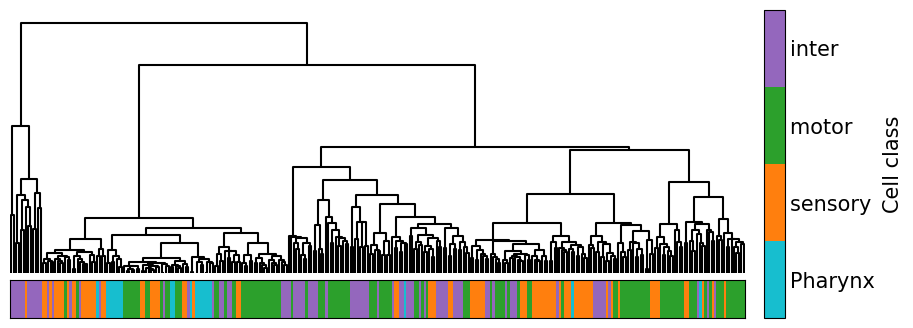

In [19]:
ncats = len(cat_to_plot) 

fig = plt.figure(figsize=(10, 3+ncats))

gs0 = GridSpec(1,2, figure=fig,width_ratios=[35,1], wspace=0.05)

gs1 = GridSpecFromSubplotSpec(1+ncats,1, subplot_spec=gs0[0],
                                                  height_ratios=[7] + [1 for _ in range(ncats)],
                                                  hspace=0.05)

gs2 = GridSpecFromSubplotSpec(ncats,1, subplot_spec=gs0[1],
                                                  height_ratios=[1 for _ in range(ncats)],
                                                  hspace=0.05)

ax_col_dendrogram = fig.add_subplot(gs1[0])

col_dendrogram = sp.cluster.hierarchy.dendrogram(Z, ax=ax_col_dendrogram, color_threshold=0, above_threshold_color='black')
ax_col_dendrogram.set_axis_off()

xind = col_dendrogram['leaves']

xmin,xmax = ax_col_dendrogram.get_xlim()

for n in range(len(plotobj)):
    legend_ax = fig.add_subplot(gs2[n])

    arr, key, cluster_cmap = plotobj[n]

    if -1 in arr:
        key = ['other'] + list(key) # if we want white space for not represented 
    
    ax = fig.add_subplot(gs1[1+n], sharex=ax_col_dendrogram)
    colrow = ax.imshow(arr[xind].reshape((1,-1)), aspect='auto', extent=[xmin,xmax,0,1], cmap=cluster_cmap, interpolation='nearest')
    ax.set_yticks([])
    # ax.set_ylabel(cat_to_plot[n], rotation=0, ha='right', va='center')
    ax.set_xticks([])
    plt.setp(ax.get_xticklabels(), visible=False)

    cbar = fig.colorbar(colrow, cax=legend_ax, label=cat_to_plot[n])
    yticks = np.linspace(*legend_ax.get_ylim(), len(key)+1)[:-1] + ((legend_ax.get_ylim()[1]-legend_ax.get_ylim()[0]) / len(key) / 2)

    cbar.set_label('Cell class', size=15)  # Set label text and size
    legend_ax.set_yticks(ticks=yticks)
    legend_ax.tick_params(axis='y', labelsize=15)
    legend_ax.set_yticklabels([i.replace('neuron', '') for i in key], size=15)
    legend_ax.tick_params(length=0)



# legend_ax = fig.add_subplot(gs2[-1])

# ax = fig.add_subplot(gs1[-1], sharex=ax_col_dendrogram)
# colrow = ax.imshow(ind_to_balance[xind].reshape((1,-1)), aspect='auto', extent=[xmin,xmax,0,1], cmap=white_to_green, interpolation='nearest')
# ax.set_yticks([])
# ax.set_ylabel('Balance Score', rotation=0, ha='right', va='center')
# ax.set_xticks([])
# plt.setp(ax.get_xticklabels(), visible=False)

# cbar = fig.colorbar(colrow, cax=legend_ax, label=cat_to_plot[n])

# cbar.set_label('Balance Score', size=15)  # Set label text and size
# legend_ax.tick_params(axis='y', labelsize=15)

# save_things=False
if save_things:
    plt.savefig(fig_dir / 'ce_weg_clustering_allsyn.pdf', dpi=300, bbox_inches='tight', transparent=True)
    plt.savefig(fig_dir / 'ce_weg_clustering_allsyn.png', dpi=300, bbox_inches='tight', transparent=True)

plt.show()

# Clustering evaluation:

In [20]:
fc_total_dict = ce_meta.loc[ind_to_id].reset_index().groupby('Final classification').Neuron.apply(list).to_dict()
fcstats_df = get_clustering_stats(Z=Z, ctype_to_id=fc_total_dict, ind_to_id=ind_to_id)
fcstats_df['av_size'] = fcstats_df['m_p']/fcstats_df['n_p']
fcstats_df['coverage'] = fcstats_df['m_p']/(fcstats_df['s_p'] + fcstats_df['m_p'])


In [21]:
print('Pure cluster coverage (coarse cell class)', fcstats_df.m_p.sum() / fcstats_df.len.sum())

Pure cluster coverage (coarse cell class) 0.782608695652174


In [22]:
print('Mean tightness (coarse cell class)', fcstats_df.pms.mean())

Mean tightness (coarse cell class) 0.35147461234417754


In [23]:
fcstats_df

,labels,len,lps,pms,n_p,m_p,s_p,av_size,coverage
0,Pharynx,20,0.350000,0.454545,6,19,1,3.166667,0.950000
1,interneuron,80,0.100000,0.267559,21,55,25,2.619048,0.687500
2,motor neuron,120,0.075000,0.419580,25,103,17,4.120000,0.858333
3,sensory neuron,79,0.088608,0.264214,23,57,22,2.478261,0.721519


In [24]:
cc_total_dict = ce_meta.loc[ind_to_id].reset_index().groupby('Cell Class').Neuron.apply(list).to_dict()
cc_stats_df = get_clustering_stats(Z=Z, ctype_to_id=cc_total_dict, ind_to_id=ind_to_id)
cc_stats_df['av_size'] = cc_stats_df['m_p']/cc_stats_df['n_p']
cc_stats_df['coverage'] = cc_stats_df['m_p']/(cc_stats_df['s_p'] + cc_stats_df['m_p'])


In [25]:
print('Pure cluster coverage (fine cell type)', cc_stats_df.m_p.sum() / cc_stats_df.len.sum())

Pure cluster coverage (fine cell type) 0.5054945054945055


In [26]:
print('Mean tightness (fine cell type)', cc_stats_df.pms.mean())

Mean tightness (fine cell type) 0.49367008392709577


In [27]:
# plt.figure(figsize=(4,3))
# plt.hist(cc_stats_df.len.values, bins=np.arange(1, 14)-0.5, color='black')
# sns.despine(offset=0.5, trim=True)
# plt.xlabel('Cell type size')
# plt.ylabel('Frequency')
# save_things=False
# if save_things:
#     plt.savefig('./figs/2025/ce_ctypes.pdf', dpi=300, transparent=True)
#     plt.savefig('./figs/2025/ce_ctypes.png',  dpi=300, transparent=True)
# plt.show()

In [28]:
# # .hist()

# plt.figure(figsize=(2,2))
# plt.hist(cc_stats_df.lps.values, color='black', bins=20)
# plt.xticks([0,0.5,1])
# plt.xlabel('Largest pure cluster')
# plt.ylabel('Frequency')
# sns.despine(offset=0.5, trim=True)
# save_things=False
# # save_things=True
# if save_things:
#     plt.savefig('./figs/2025/ce_ctypes_lpc.pdf', dpi=300, transparent=True)
#     plt.savefig('./figs/2025/ce_ctypes_lpc.png',  dpi=300, transparent=True)

# plt.show()

In [29]:

# plt.figure(figsize=(2,2))
# plt.hist(cc_stats_df.pms.values, color='black', bins=20)
# sns.despine(offset=0.5, trim=True)
# plt.xlabel('Tightness')
# plt.ylabel('Frequency')
# save_things=False
# # save_things=True
# if save_things:
#     plt.savefig('./figs/2025/ce_ctypes_t.pdf', dpi=300, transparent=True)
#     plt.savefig('./figs/2025/ce_ctypes_t.png',  dpi=300, transparent=True)

# plt.show()